# Constrained Expected Improvement

This section demonstrates constrained Expected Improvement (EI) which is a widely used criteria for performing constrained balanced exploration and exploitation. The next infill point is obtained by maximizing EI while taking into account the constraints. The optimization problem is written as

$$
    \begin{align*}
        \max_{x} \quad & EI(x) \\
        \text{s.t.} \quad & \hat{g}_j(x) \leq 0, \quad j = 1, \ldots, J
    \end{align*}
$$

where $\hat{g}_j(x)$ is the constraint model and $J$ is the number of constraints. The EI is defined [here](../seq_sampling/ei.ipynb). Below code imports required packages, defines modified branin function, constraint, and creates plotting data:

In [2]:
# Imports
import numpy as np
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from scipy.stats import norm as normal

def modified_branin(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    b = 5.1 / (4*np.pi**2)
    c = 5 / np.pi
    t = 1 / (8*np.pi)

    y = (x2 - b*x1**2 + c*x1 - 6)**2 + 10*(1-t)*np.cos(x1) + 10 + 5*x1

    if dim == 1:
        y = y.reshape(-1)

    return y

def constraint(x):

    dim = x.ndim

    if dim == 1:
        x = x.reshape(1, -1)

    x1 = x[:,0]
    x2 = x[:,1]

    g = -x1*x2 + 30
    
    if dim == 1:
        g = g.reshape(-1)

    return g

# Bounds
lb = np.array([-5, 0])
ub = np.array([10, 15])

# Plotting data
sampler = FullFactorial(xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ))
num_plot = 400
xplot = sampler(num_plot)
yplot = modified_branin(xplot)
gplot = constraint(xplot)

Differential evolution (DE) from `pymoo` is used for maximizing the EI. Below code defines problem class and initializes DE. Note how problem class computes EI and constraint prediction.

In [6]:
# Problem class
class ConstrainedEI(Problem):

    def __init__(self, sm_func, sm_const, ymin):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=1, xl=lb, xu=ub)

        self.sm_func = sm_func
        self.sm_const = sm_const
        self.ymin = ymin

    def _evaluate(self, x, out, *args, **kwargs):

        # Standard normal
        numerator = self.ymin - self.sm_func.predict_values(x)
        denominator = np.sqrt( self.sm_func.predict_variances(x) )
        z = numerator / denominator
        
        # Computing expected improvement
        # Negative sign because we want to maximize EI
        out["F"] = - ( numerator * normal.cdf(z) + denominator * normal.pdf(z) )
        out["G"] = self.sm_const.predict_values(x)

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

Below block of code creates 5 training points and performs sequential sampling process using constrained EI. The maximum number of iterations is set to 20 and a convergence criterion is defined based on maximum value of EI obtained in each iteration.

In [18]:
sampler = LHS( xlimits=np.array( [[lb[0], ub[0]], [lb[1], ub[1]]] ), criterion='ese')

# Training data
num_train = 5
xtrain = sampler(num_train)
ytrain = modified_branin(xtrain)
gtrain = constraint(xtrain)

# Variables
itr = 0
max_itr = 20
tol = 1e-3
max_EI = [1]
ybest = []
bounds = [(lb[0], ub[0]), (lb[1], ub[1])]
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
while itr < max_itr and tol < max_EI[-1]:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Initializing the kriging model
    sm_func = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)
    sm_const = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm_func.set_training_values(xtrain, ytrain)
    sm_const.set_training_values(xtrain, gtrain)

    # Creating surrogate model
    sm_func.train()
    sm_const.train()

    # Find the best feasible sample
    ybest.append(np.min(ytrain[gtrain < 0]))
    index = np.where(ytrain == ybest[-1])[0][0]

    # Find the minimum of surrogate model
    result = minimize(ConstrainedEI(sm_func, sm_const, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = modified_branin(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[index,:].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[index,:]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    gtrain = np.append( gtrain, constraint(result.X.reshape(1,-1)) )
    
    itr = itr + 1 # Increasing the iteration number

# Printing the final results
print("\nBest feasible point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))
print("g*: {}".format(gtrain[index]))


Iteration 1
Maximum EI: 37.738954035545255
Best observed value: 73.92330725031167

Iteration 2
Maximum EI: 26.970418574380325
Best observed value: 73.92330725031167

Iteration 3
Maximum EI: 17.551385185368645
Best observed value: 73.92330725031167

Iteration 4
Maximum EI: 21.45243187907727
Best observed value: 73.92330725031167

Iteration 5
Maximum EI: 0.7580410543815712
Best observed value: 53.211626426882724

Iteration 6
Maximum EI: 0.07178259197236336
Best observed value: 52.591351315035105

Iteration 7
Maximum EI: 0.2876813283644024
Best observed value: 52.591351315035105

Iteration 8
Maximum EI: 3.393719572963191
Best observed value: 52.591351315035105

Iteration 9
Maximum EI: 1.1145731861828956
Best observed value: 52.591351315035105

Iteration 10
Maximum EI: 0.010068960341427877
Best observed value: 47.588006766632596

Iteration 11
Maximum EI: 0.0005706239412082868
Best observed value: 47.56364919606263

Best feasible point:
x*: [9.16860788 3.27207233]
f*: 47.56364919606263
g*:

> __*NOTE*__: The minimum obtained at the end of process is minimum feasible $y$ observed in the training data and **not** minimum of the surrogate model.

Below block of code plots the convergence of best observed value and expected improvement.

Text(0.5, 0.98, 'Expected Improvement')

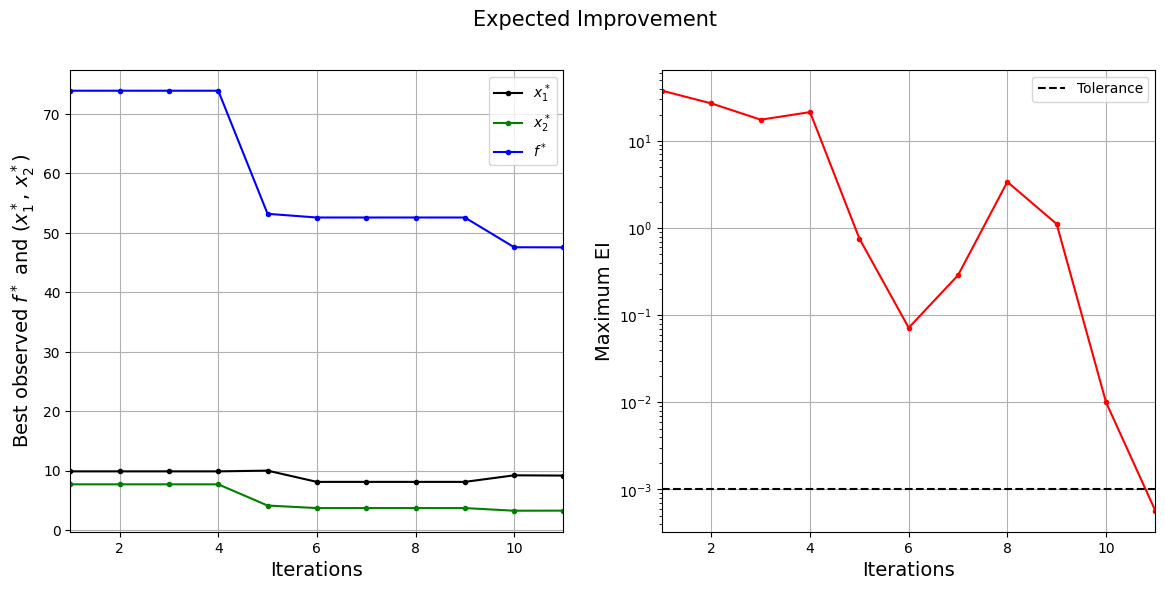

In [19]:
####################################### Plotting convergence history

fig, ax = plt.subplots(1, 2, figsize=(14,6))
ax[0].plot(np.arange(itr) + 1, xbest[:,0], c="black", label='$x_1^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, xbest[:,1], c="green", label='$x_2^*$', marker=".")
ax[0].plot(np.arange(itr) + 1, ybest, c="blue", label='$f^*$', marker=".")
ax[0].set_xlabel("Iterations", fontsize=14)
ax[0].set_ylabel("Best observed $f^*$ and ($x_1^*$, $x_2^*$)", fontsize=14)
ax[0].legend()
ax[0].set_xlim(left=1, right=itr)
ax[0].grid()

ax[1].plot(np.arange(itr) + 1, max_EI, c="red", marker=".")
ax[1].plot(np.arange(itr) + 1, [tol]*(itr), c="black", linestyle="--", label="Tolerance")
ax[1].set_xlabel("Iterations", fontsize=14)
ax[1].set_ylabel("Maximum EI", fontsize=14)
ax[1].set_xlim(left=1, right=itr)
ax[1].grid()
ax[1].legend()
ax[1].set_yscale("log")

fig.suptitle("Expected Improvement", fontsize=15)

The figure on left shows the history of best feasible $y$ value and corresponding $x$ values, and figure on right shows the convergence of EI. At the start, EI is high since the amount of possible improvement over the current best feasible point is high. As the iterations progress, the best feasible value reaches the global minimum and the EI decreases. Also, note that process stopped before reaching maximum number of infills since the convergence criteria was met.

Below code plots the infill points.

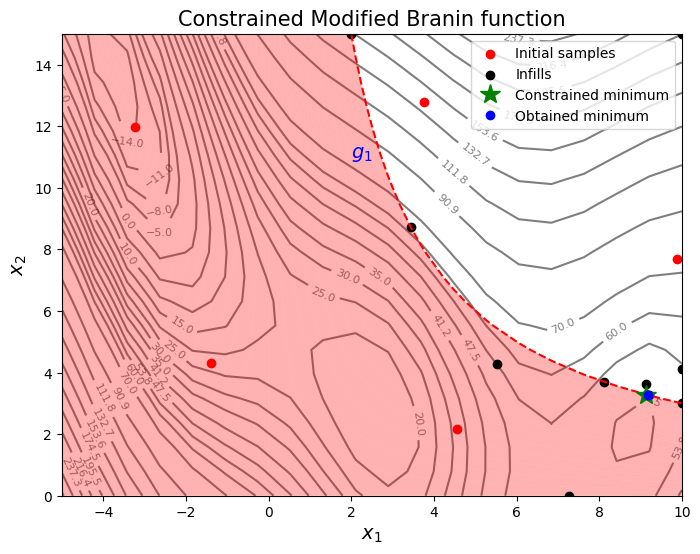

In [21]:
####################################### Plotting initial samples and infills

# Reshaping into grid
reshape_size = int(np.sqrt(num_plot))
X = xplot[:,0].reshape(reshape_size, reshape_size)
Y = xplot[:,1].reshape(reshape_size, reshape_size)
Z = yplot.reshape(reshape_size, reshape_size)
G = gplot.reshape(reshape_size, reshape_size)

# Level
levels = np.linspace(-17, -5, 5)
levels = np.concatenate((levels, np.linspace(0, 30, 7)))
levels = np.concatenate((levels, np.linspace(35, 60, 5)))
levels = np.concatenate((levels, np.linspace(70, 300, 12)))

fig, ax = plt.subplots(figsize=(8,6))

# Plot function
CS=ax.contour(X, Y, Z, levels=levels, colors='k', linestyles='solid', alpha=0.5, zorder=-10)
ax.clabel(CS, inline=1, fontsize=8)

# Plot constraint
ax.contour(X, Y, G, levels=[0], colors='r', linestyles='dashed')
ax.contourf(X, Y, G, levels=np.linspace(0,G.max()), colors="red", alpha=0.3, antialiased = True)
ax.annotate('$g_1$', xy =(2.0, 11.0), fontsize=14, color='b')

# Plot minimum
ax.scatter(xtrain[0:num_train,0], xtrain[0:num_train,1], c="red", label='Initial samples')
ax.scatter(xtrain[num_train:,0], xtrain[num_train:,1], c="black", label='Infills')
ax.plot(9.143, 3.281, 'g*', markersize=15, label="Constrained minimum")
ax.plot(xtrain[index,0], xtrain[index,1], 'bo', label="Obtained minimum")

# Asthetics
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.set_title("Constrained Modified Branin function", fontsize=15)
ax.legend()

From the above plots, it can be seen that expected improvement finds the minimum of modified branin function while balancing exploration and exploitation.

> __*NOTE*__: Due to randomness in differential evolution, results may vary slightly between runs. So, it is recommended to run the code multiple times to see average behavior.

Final result:

| Parameter         | True minimum | Obtained minimum|
|-------------------|--------------|-----------------|
| $x_1^*$           | 9.143        | 9.167           |
| $x_2^*$           | 3.281        | 3.272           |
| $f(x_1^*, x_2^*)$ | 47.560       | 47.564          |
| $g_1(x_1^*, x_2^*)$ | 0.0        | -3.481 $\cdot 10^{-4}$|